In [1]:
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

from skbio import OrdinationResults
from biom import load_table

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## load data

In [2]:
#import 
metadata = pd.read_csv('../data/split-matched-data/metadata.tsv', index_col=0, sep='\t')
tables = {i.split('/')[-1].split('.')[0]:load_table(i) for i in glob.glob('../data/split-matched-data/*') if 'metadata' not in i}

In [3]:
# load results from prior run
omic_ids = ['16S', 'mag', '18S', 'gene_module', 'gene', 'metabolomics']
rpca_independent = {omic: (OrdinationResults.read('../results/joint-rpca/Original/{}_ord.txt'.format(omic)),
                           #(OrdinationResults.read('../results/joint-rpca/Ordinations/{}_ord_4PCs.txt'.format(omic)),
                           None, ##we don't really need the distance matrix for the analysis here! 
                           None) for omic in omic_ids}

In [4]:
# load results form prior run
joint_rpca_results = {'joint': (OrdinationResults.read('../results/joint-rpca/Original/ord.txt'), None, None) }
#joint_rpca_results = {'joint': (OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_4PCs.txt'), None, None) }

## 2D scatterplots

In [5]:
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

def ordination_scatterplots(rpca_results, metadata, x="PC1", y="PC2",
                            hue=None, hue_order=None, palette="tab10", 
                            markers=None, style=None, style_order=None, 
                            colorbar=False, cbar_label=None, point_size=100, 
                            subplots=(2,3), figsize=(25, 10),
                            save_fig=False, save_path=None):

    if subplots is not None:
        fig, axn = plt.subplots(subplots[0], subplots[1], figsize=figsize)
        axn = axn.flatten()
    else:
        fig = plt.figure(figsize=figsize)
        axn = [plt.gca()]

    omic_title = {'18S': '18S', '16S': '16S', 'mag': 'MAG', 'gene': 'Gene',
                  'gene_module': 'Gene Module', 'metabolomics': 'Metabolomics',
                  'joint': 'Joint-RPCA'}

    for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_results.items()):
        #prepare dataframe
        ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                                   2:'PC3', 3:'PC4'})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)

        #plotting
        sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, 
                        palette=palette, style=style, 
                        style_order=style_order, markers=markers, 
                        data=ord_plt, s=point_size, ax=ax)
        ax.set_xlabel(x, color='black', weight='bold', fontsize=22)
        ax.set_ylabel(y, color='black', weight='bold', fontsize=22)
        ax.set_title(omic_title[tblid], color='black', weight='bold', fontsize=22)
        
        #fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
    
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
        
        hue_dtype = metadata[hue].dtype
        if (hue_dtype!='float64') and (hue_dtype!='int64'):
            ax.legend_.remove()
        
        if (subplots is not None) and (colorbar):
            norm = plt.Normalize(metadata[hue].min(), metadata[hue].max())
            sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
            sm.set_array([])
            ax.legend_.remove()
            cbar = ax.figure.colorbar(sm, location='right', shrink=0.8,
                                      anchor=(0.0, 0.5), ax=ax)
            cbar.ax.tick_params(labelsize=16)
            cbar.set_label(cbar_label, labelpad=-70, y=0.5, 
                           fontsize=20, weight='bold')
            
    plt.tight_layout()

    if (subplots is not None) and (colorbar == False):
        ncats = metadata[hue].nunique()
        legend = ax.legend(loc=2, bbox_to_anchor=(-1.1, 2.6),
                           prop={'size':22}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=ncats, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        #increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
    
    elif (subplots is None) and (colorbar == False):
        legend = ax.legend(loc=2, bbox_to_anchor=(1, 1),
                           prop={'size':18}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=1, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        #increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)

    if (colorbar) and (subplots is None):
        norm = plt.Normalize(metadata[hue].min(), metadata[hue].max())
        sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
        sm.set_array([])

        # Remove the legend and add a colorbar
        ax.get_legend().remove()
        cbar = ax.figure.colorbar(sm, location='right', shrink=0.8,
                                  anchor=(0.0, 0.5), ax=axn[-1])
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(cbar_label, labelpad=-65, y=0.5, 
                       fontsize=20, weight='bold')

    if save_fig:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        
    plt.show()

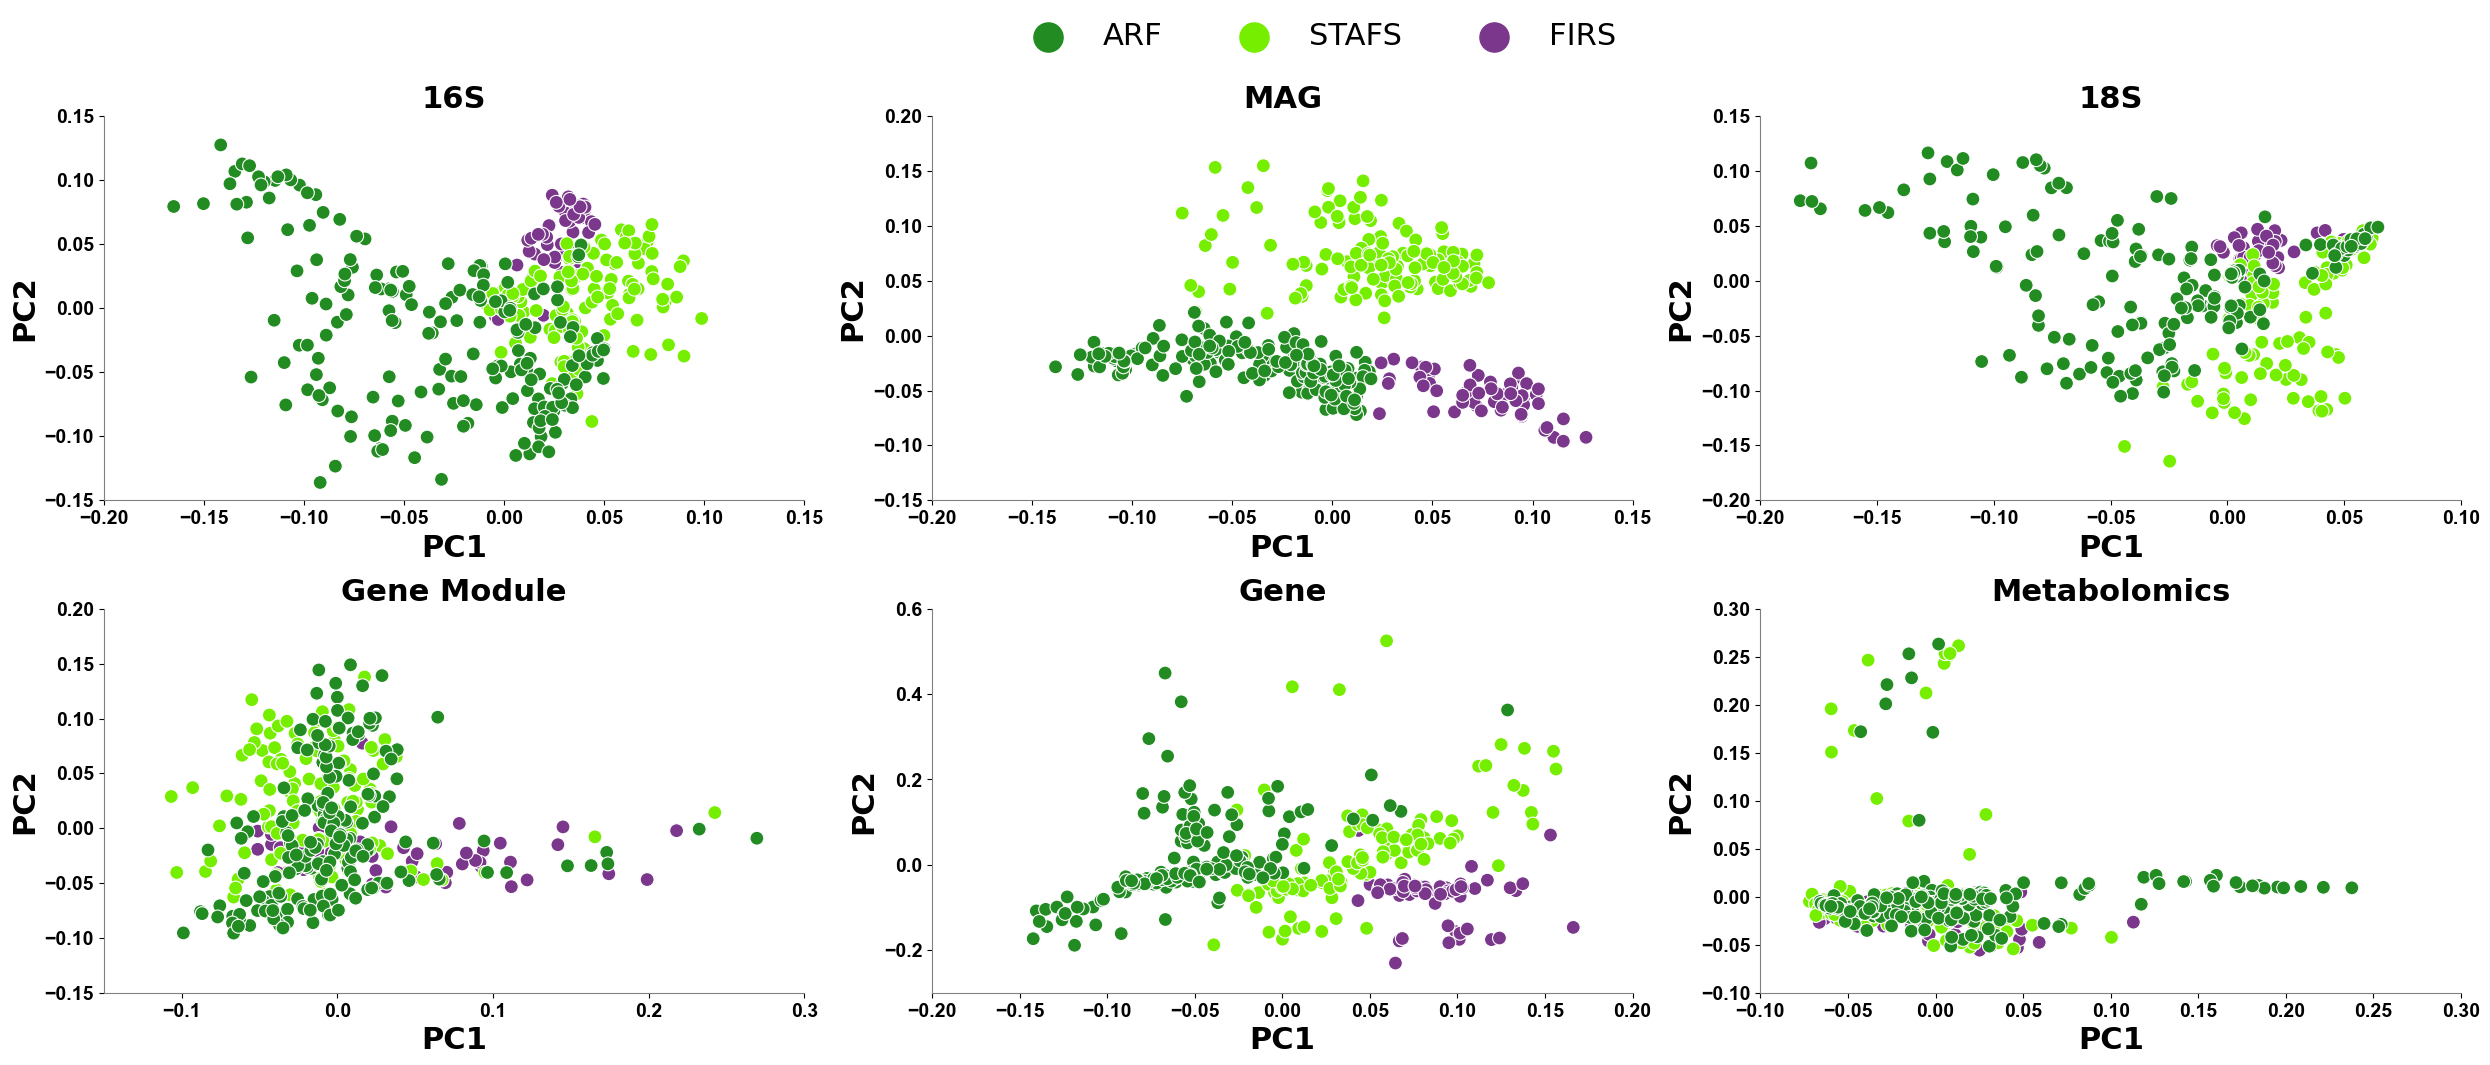

In [6]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
                        x="PC1", y="PC2", palette=["#228b22","#76ee00","#7a378b"], 
                        subplots=(2,3), save_fig=False, figsize=(25, 10),
                        save_path='../results/joint-rpca/figures/rpca-ord-facility-scatter.pdf')

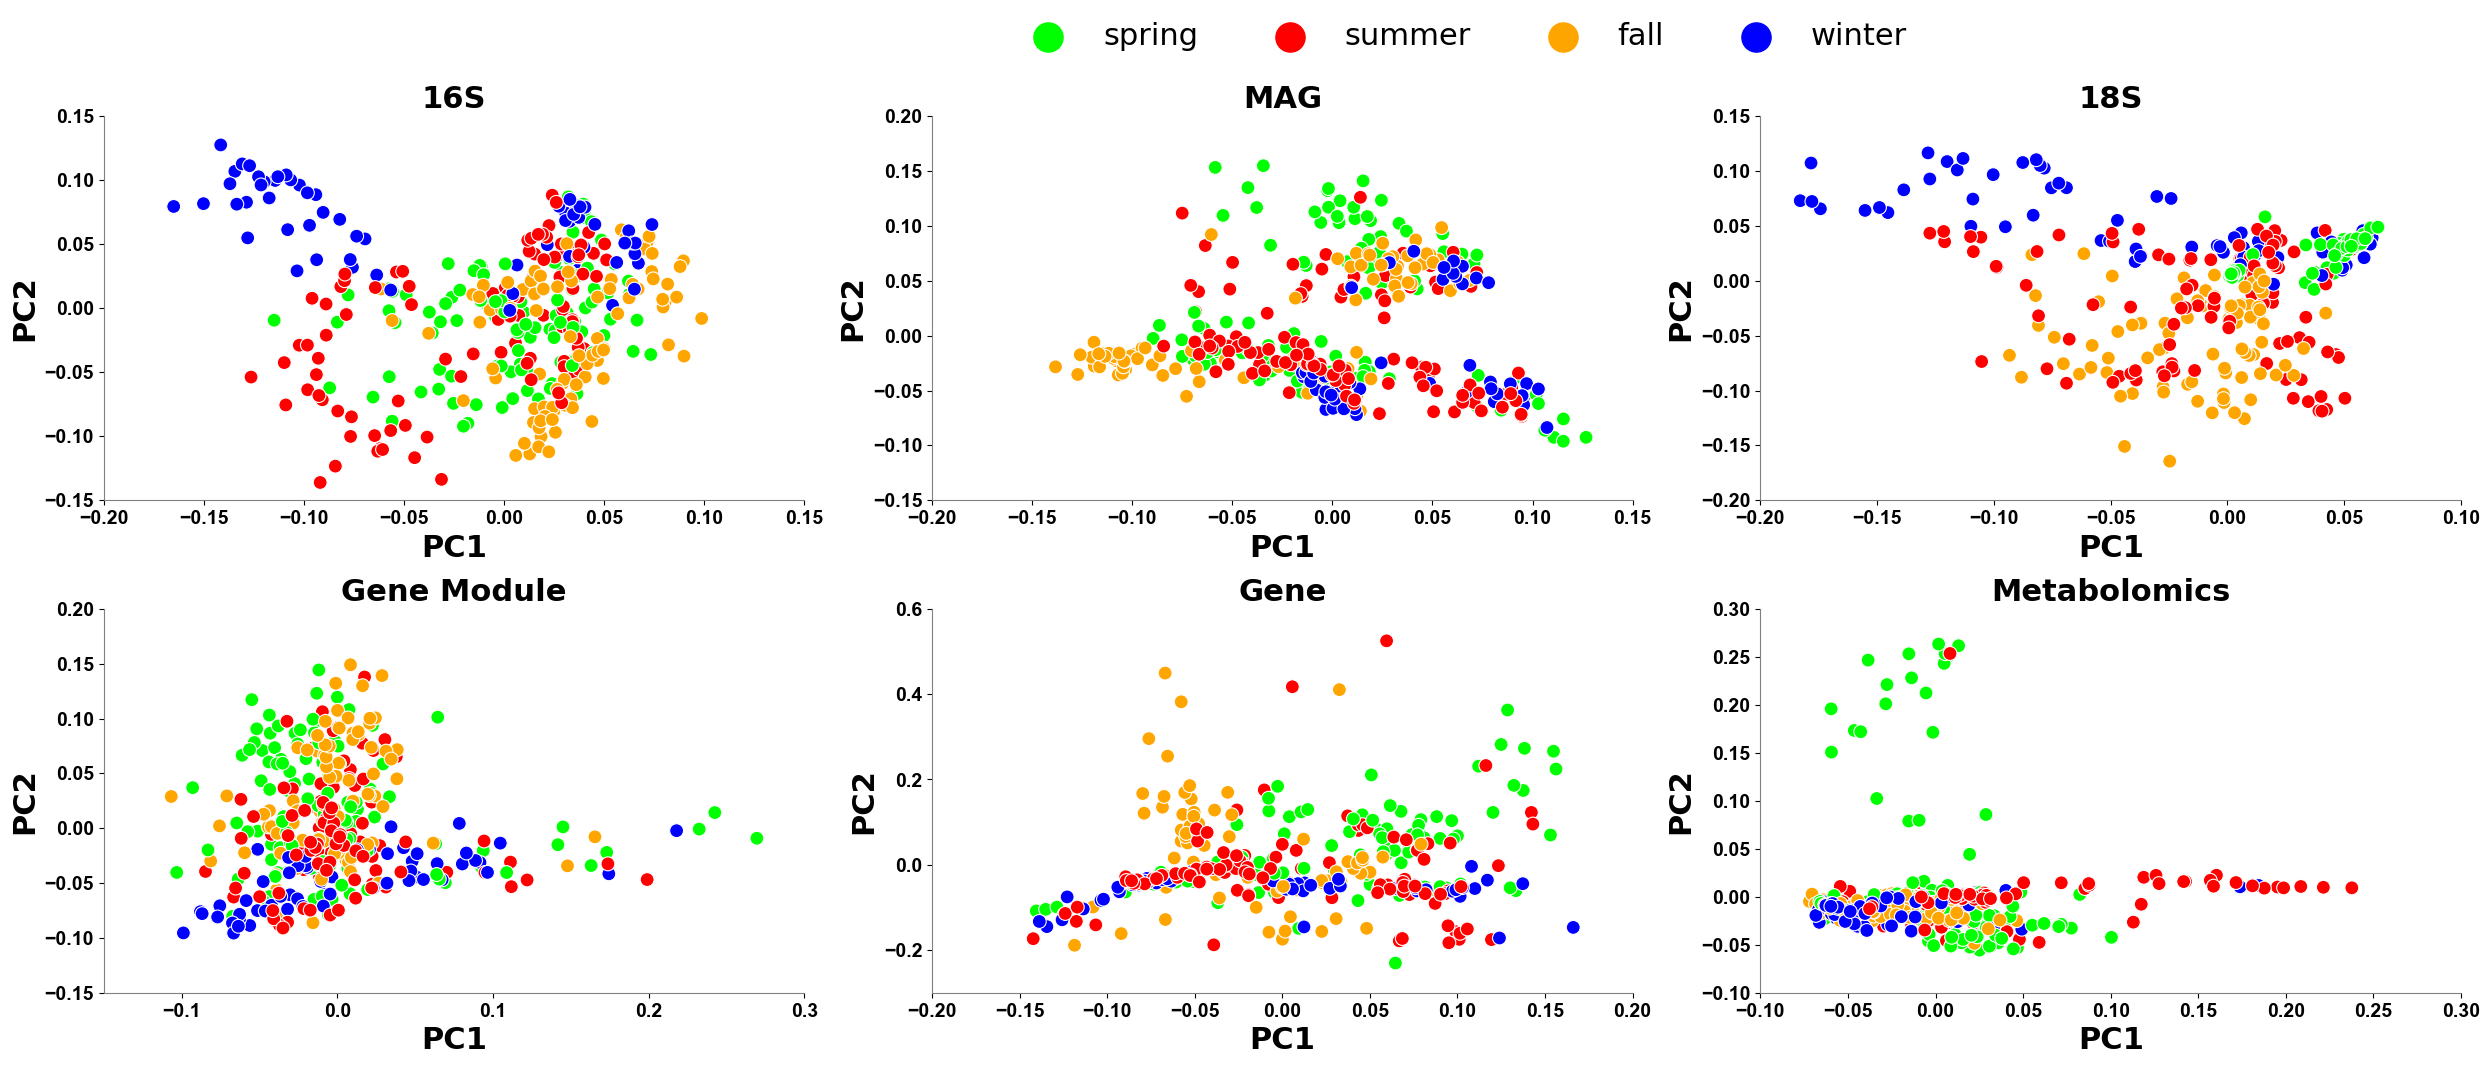

In [7]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="season", hue_order=['spring', 'summer', 'fall','winter'], 
                        x="PC1", y="PC2", palette=["#00FF00","#FF0000","#FFA500", "#0000FF"], 
                        subplots=(2,3), save_fig=False, figsize=(25, 10),
                        save_path='../results/joint-rpca/figures/rpca-ord-season-scatter.pdf')

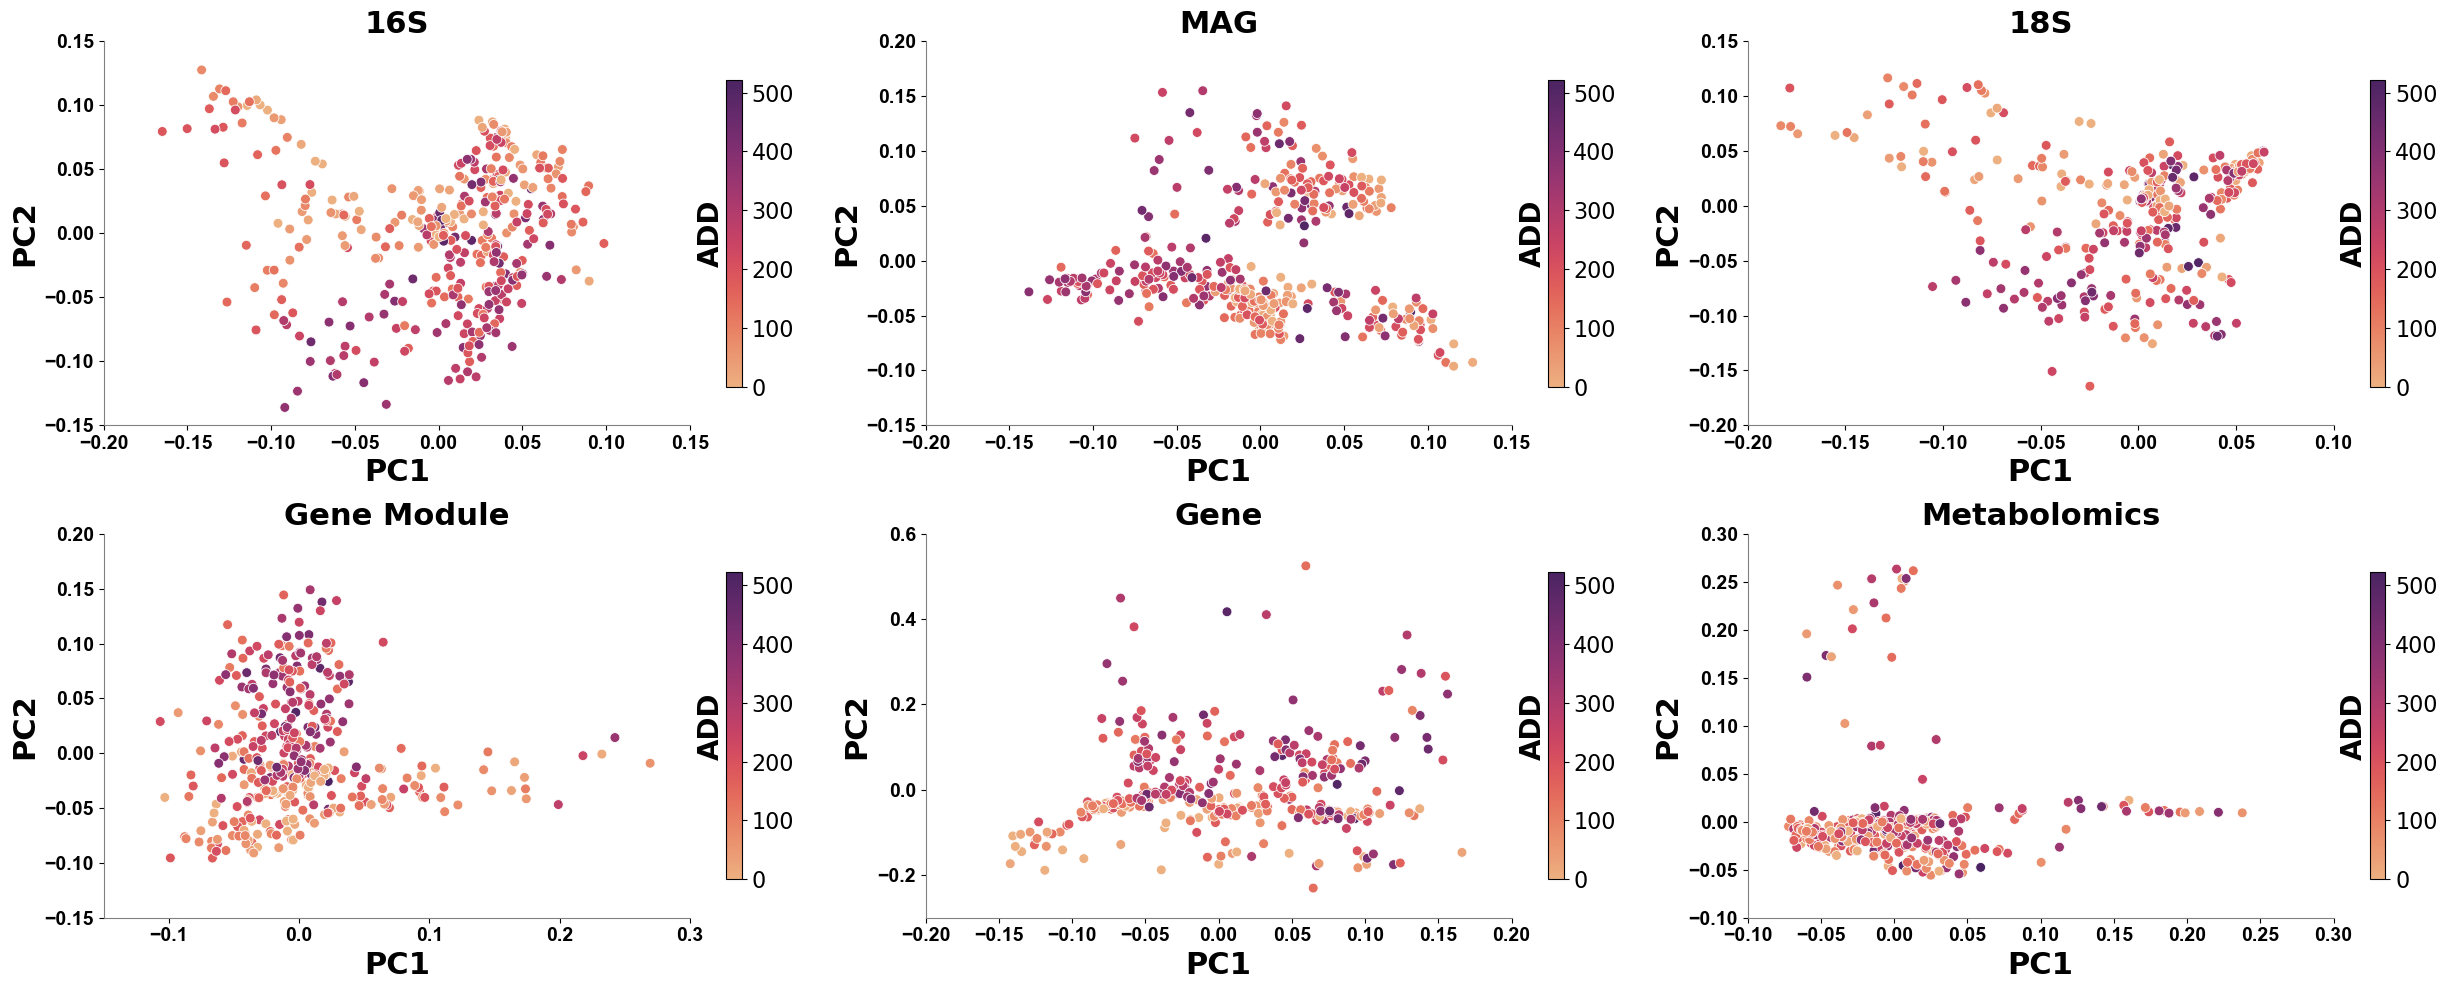

In [8]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="add_0c", hue_order=None, cbar_label='ADD',
                        x="PC1", y="PC2", colorbar=True, point_size=50,
                        palette=sns.color_palette("flare", as_cmap=True),
                        subplots=(2,3), save_fig=True, figsize=(25, 10),
                        save_path='../results/joint-rpca/figures/rpca-ord-add-cont-scatter.pdf')

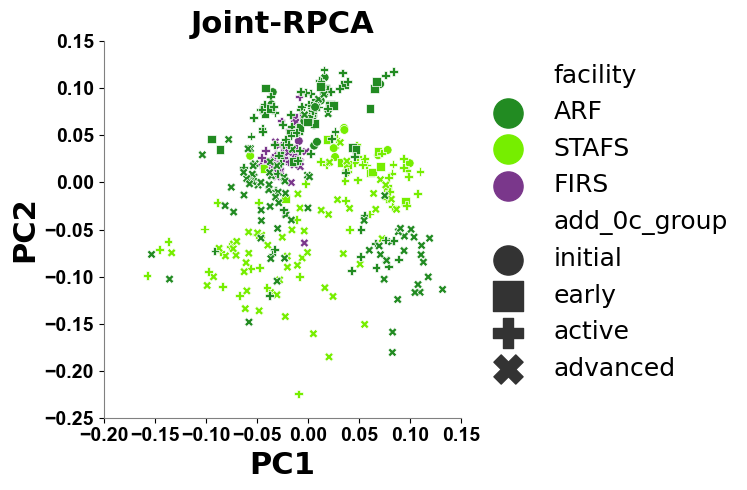

In [14]:
palette=["#228b22","#76ee00","#7a378b"]
markers = {"initial": "o", "early": "s", "active": "P", "advanced": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
                        palette=palette, markers=markers, style='add_0c_group',
                        style_order=['initial', 'early', 'active', 'advanced'], 
                        point_size=40, subplots=None, figsize=(5, 5), save_fig=False,
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-facility-scatter.pdf')

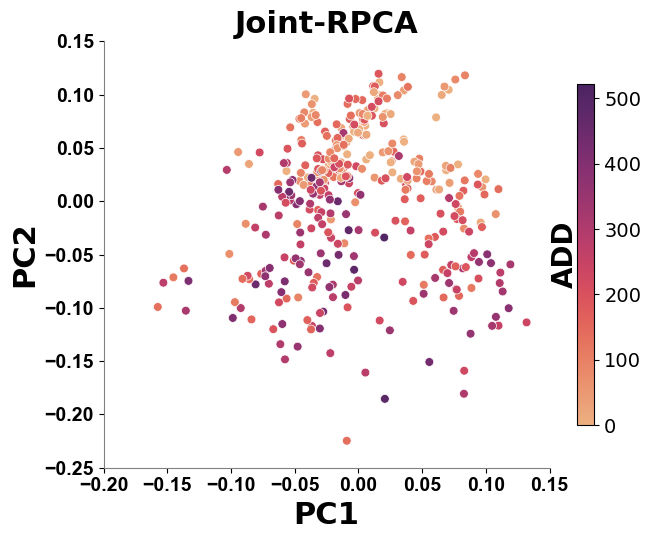

In [22]:
ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="add_0c", hue_order=None, colorbar=True, cbar_label='ADD',
                        palette=sns.color_palette("flare", as_cmap=True),
                        markers=None, style=None, style_order=None, 
                        point_size=40, subplots=None, figsize=(7, 5.5), save_fig=True, 
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-add3-scatter.pdf')

## 3D scatterplots

In [16]:
def ord_scatter_3D(rpca_results, metadata, 
                   hue, hue_order, 
                   pcs=["PC1","PC2","PC3"], palette="tab10", 
                   subplots=(2,3), figsize=(25, 10)):

    if subplots is not None:
        fig, axn = plt.subplots(subplots[0], subplots[1], figsize=figsize,
                                subplot_kw=dict(projection='3d'))
        axn = axn.flatten()
    else:
        ax = plt.figure(figsize=figsize).add_subplot(projection='3d')
        axn = [ax]

    for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_results.items()):
        #prepare dataframe
        ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                                   2:'PC3', 3:'PC4'})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)
        #assign colors
        if hue_order is None:
            c = ord_plt[hue]
            cmap = palette
            patches = []
            ncol = 1
        else:
            cmap = None
            color_dict = dict(zip(hue_order, palette))
            ord_plt['Color'] = ord_plt[hue].map(color_dict)
            c = ord_plt['Color']
            patches = [mpatches.Patch(color=value, label=key) for 
                       key, value in color_dict.items()]
            ncol = len(hue_order)

        ax.scatter(xs=ord_plt[pcs[0]], ys=ord_plt[pcs[1]],  
                   zs=ord_plt[pcs[2]], c=c, marker='o', cmap=cmap)

        ax.set_xlabel(pcs[0], color='black', weight='bold', fontsize=15)
        ax.set_ylabel(pcs[1], color='black', weight='bold', fontsize=15)
        ax.set_zlabel(pcs[2], color='black', weight='bold', fontsize=15)
        ax.set_title(tblid, color='black', weight='bold', fontsize=15)

        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 15
        ax.zaxis.labelpad = 15
        
        # fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

    if subplots is not None:
        legend = ax.legend(handles=patches, loc=9, title='', prop={'size':18},
                           bbox_to_anchor=(-0.9, 2.5), fancybox=True, framealpha=.0,
                           ncol=ncol, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        fig.subplots_adjust(wspace=-0.5, hspace=0.2)
    
    else:
        legend = ax.legend(handles=patches, loc=2, bbox_to_anchor=(1.05, 1.1),
                           title='', prop={'size':18}, fancybox=True, framealpha=.0,
                           ncol=1, markerscale=3.5)
        legend.get_title().set_fontsize('16')

        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
    
    #plt.tight_layout()
    plt.show()

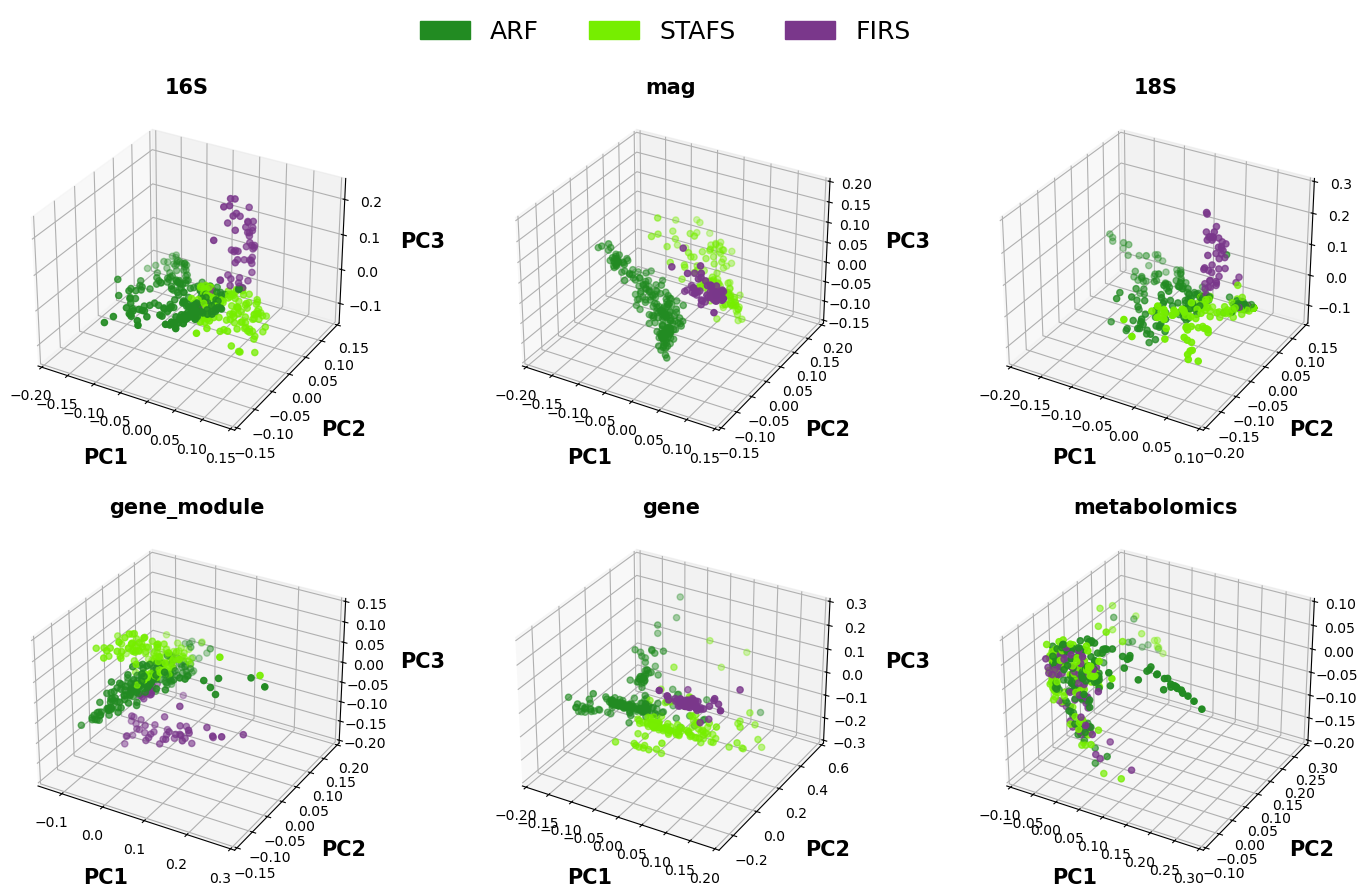

In [17]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
               pcs=["PC1","PC2","PC3"], palette=["#228b22","#76ee00","#7a378b"], 
               subplots=(2,3), figsize=(25, 10))

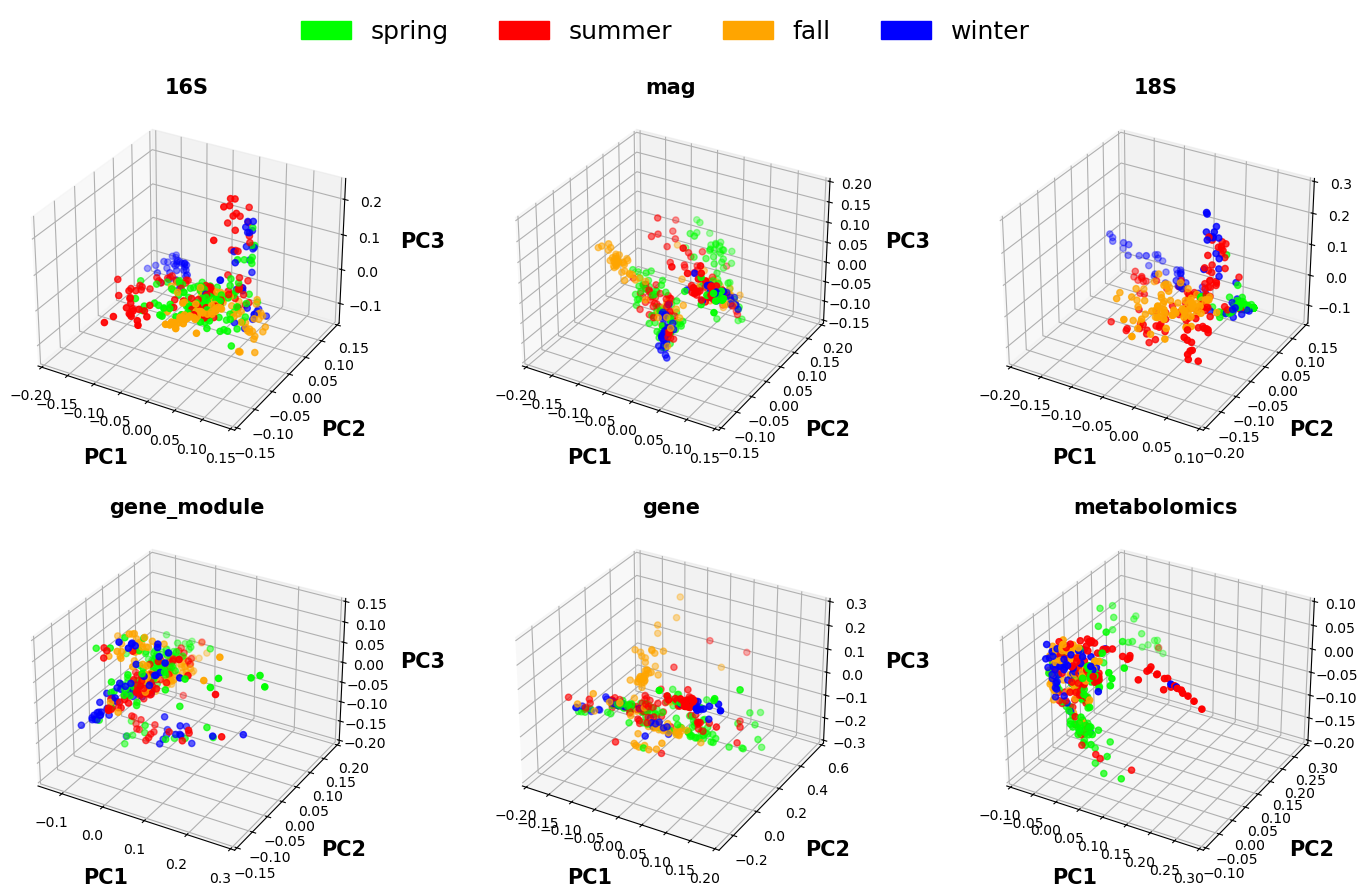

In [18]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="season", hue_order=['spring', 'summer', 'fall','winter'], 
               pcs=["PC1","PC2","PC3"], palette=["#00FF00","#FF0000","#FFA500", "#0000FF"], 
               subplots=(2,3), figsize=(25, 10))

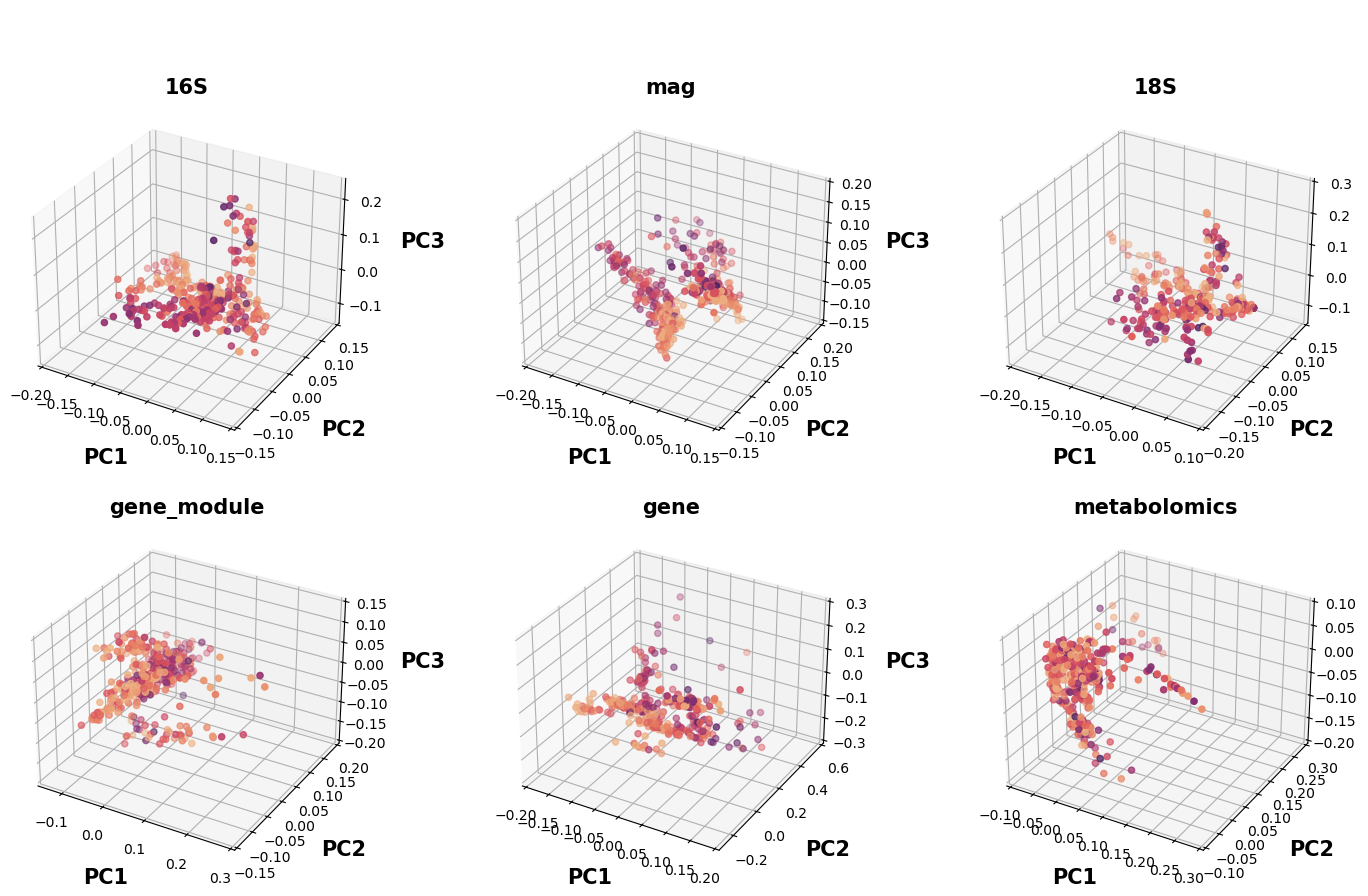

In [19]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="add_0c", hue_order=None, 
               pcs=["PC1","PC2","PC3"], 
               palette=sns.color_palette("flare", as_cmap=True), 
               subplots=(2,3), figsize=(25, 10))

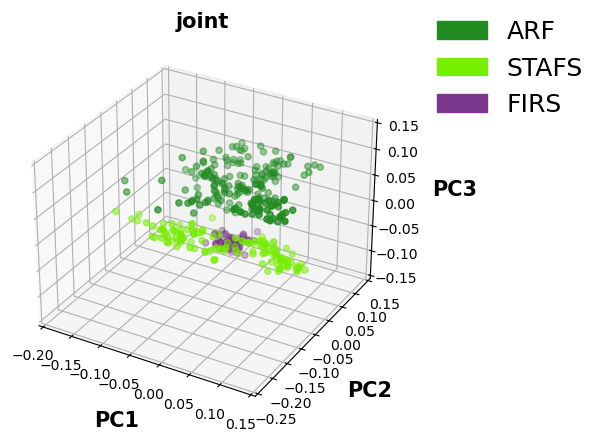

In [20]:
ord_scatter_3D(joint_rpca_results, metadata, 
               hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
               pcs=["PC1","PC2","PC3"], palette=["#228b22","#76ee00","#7a378b"], 
               subplots=None, figsize=(5, 5))

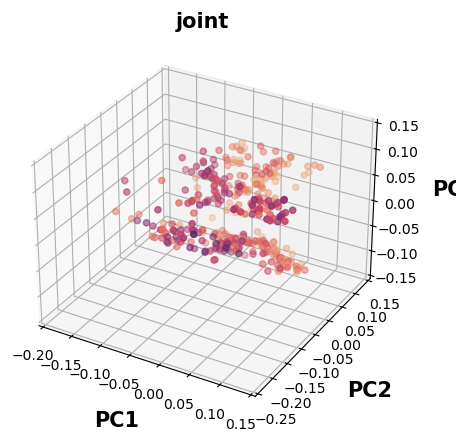

In [21]:
ord_scatter_3D(joint_rpca_results, metadata, 
               hue="add_0c", hue_order=None, 
               pcs=["PC1","PC2","PC3"], 
               palette=sns.color_palette("flare", as_cmap=True), 
               subplots=None, figsize=(5, 5))